In [ ]:
#importing libraries
from data_loader import FootballDataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Masking, GRU, Dense, Dropout, TimeDistributed, RepeatVector
)
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error

Reading game 1: Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Loading Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Data read.
Time shape: (155541, 2)
Ball shape: (155541, 5)
Team shape: (155541, 45)
Opponent shape: (155541, 48)
Total shape: (88002, 100)
Opponent name detected from filename: RFC

=== DataFrame Overview ===
Shape: (88002, 100)

Columns:
['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y', 'FCKplayer_1_number', 'FCKplayer_2_x', 'FCKplayer_2_y', 'FCKplayer_2_number', 'FCKplayer_4_x', 'FCKplayer_4_y', 'FCKplayer_4_number', 'FCKplayer_8_x', 'FCKplayer_8_y', 'FCKplayer_8_number', 'FCKplayer_10_x', 'FCKplayer_10_y', 'FCKplayer_10_number', 'FCKplayer_11_x', 'FCKplayer_11_y', 'FCKplayer_11_number', 'FCKplayer_13_x', 'FCKplayer_13_y', 'FCKplayer_13_number', 'FCKplayer_18_x', 'FCKplayer_18_y', 'FCKplayer_18_number', 'FCKplayer_24_x', 'FCKplayer_24_y', 'FCKplayer_24_number', 'FCKplayer_27_x', 'FCKplayer_27_y', 'FCKplayer_27_number', 'FCKp

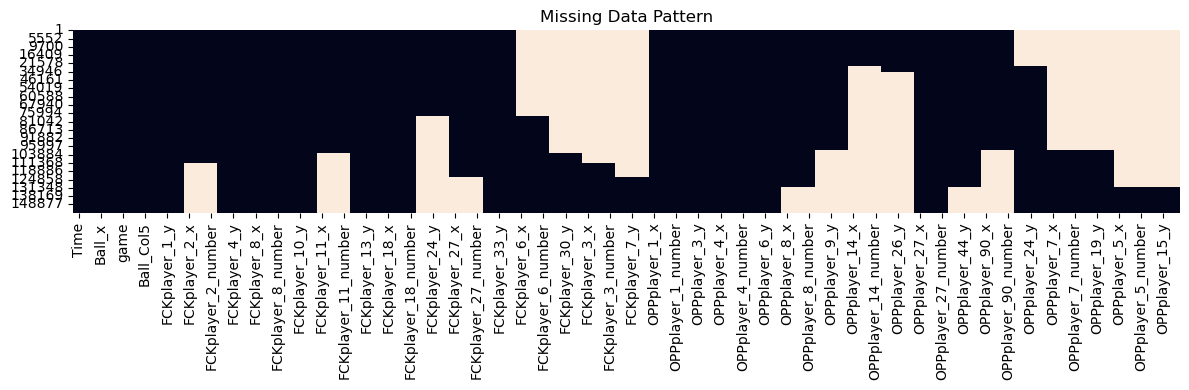

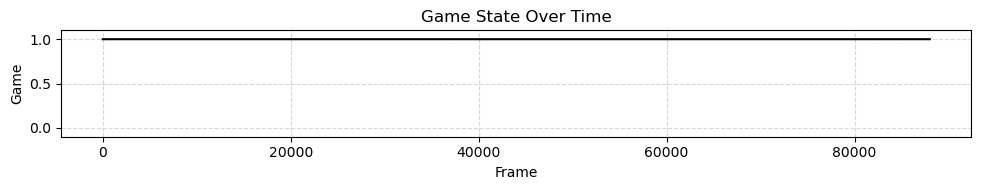

In [ ]:
#loading data
#Getting the data
data_dir = r"\Users\kirlo\Documents\Sanvi University Work\Year 3\AML\final project\FootballData\RestructuredData_2425"  # replace with your actual data directory
team = "SIF"         
data_retriever = FootballDataLoader(data_dir, team)
all_games = data_retriever.load_all_games(n_games='all', speed_player= False, speed_ball=False, player_z=False, ball_z = True, )  


In [ ]:
#reducing columns
game = all_games[4]
cols = ['Ball_x', 'Ball_y', 'Ball_z'] + [col for col in game.columns if ('player' in col and (col.endswith('_x') or col.endswith('_y')))]
game = game[cols]
#game.drop('Ball_z', axis = 1, inplace= True)
scaler = StandardScaler()
game_scaled = pd.DataFrame(
    scaler.fit_transform(game),
    columns=game.columns,
    index=game.index
)
#Padding the data
pad_value = 0.0
game_scaled = np.nan_to_num(game_scaled, nan = pad_value )
sequence_length = 10

# Define features: everything except Ball_x and Ball_y
feature_columns = [col for col in game.columns if col not in ['Ball_x', 'Ball_y']]

# Find column indices
target_cols = ['Ball_x', 'Ball_y']
target_indices = [game.columns.get_loc(col) for col in target_cols]
feature_indices = [game.columns.get_loc(col) for col in feature_columns]

# Convert to NumPy array if not already
game_scaled_np = game_scaled.to_numpy() if isinstance(game_scaled, pd.DataFrame) else game_scaled

X = []
y = []

for i in range(len(game_scaled_np) - sequence_length):
    # Input: sequence of player features
    X.append(game_scaled_np[i:i+sequence_length, feature_indices])
    
    # Output: Ball_x and Ball_y at the next timestep
    y.append(game_scaled_np[i + sequence_length, target_indices])

X = np.array(X)
y = np.array(y)

print(X.shape)  # Should be (samples, sequence_length, num_features)
print(y.shape)  # Should be (samples, 2)

#Building RNN
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])),
    GRU(64, return_sequences=False),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss= 'mse')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
from tensorflow.keras.callbacks import EarlyStopping
#training model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
ball_predictions = model.predict(X_test)
ball_predictions.shape

# Create a full-sized zero array to hold placeholder feature values
temp = np.zeros((ball_predictions.shape[0], scaler.mean_.shape[0]))

# Find the column indices of 'Ball_x' and 'Ball_y'
ball_x_idx = game.columns.get_loc('Ball_x')
ball_y_idx = game.columns.get_loc('Ball_y')

# Fill in the predicted values in the appropriate columns
temp[:, ball_x_idx] = ball_predictions[:, 0]
temp[:, ball_y_idx] = ball_predictions[:, 1]

# Inverse transform the full array
unnorm = scaler.inverse_transform(temp)

# Extract only Ball_x and Ball_y from the unnormalized output
ball_pred_df = pd.DataFrame(
    unnorm[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

y_test_df = pd.DataFrame(
    scaler.inverse_transform(
        np.hstack([
            y_test,
            np.zeros((y_test.shape[0], scaler.mean_.shape[0] - y_test.shape[1]))
        ])
    )[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)



# Compute RMSE for Ball_x and Ball_y
rmse_x = np.sqrt(mean_squared_error(y_test_df['Ball_x'], ball_pred_df['Ball_x']))
rmse_y = np.sqrt(mean_squared_error(y_test_df['Ball_y'], ball_pred_df['Ball_y']))

print(f"RMSE Ball_x: {rmse_x:.3f}")
print(f"RMSE Ball_y: {rmse_y:.3f}")

# Ensure ball_pred_df and actual values are aligned
n_preds = len(ball_pred_df)
actual_ball = game[['Ball_x', 'Ball_y']].iloc[sequence_length:sequence_length + n_preds].reset_index(drop=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Ball_x
axs[0].scatter(ball_pred_df['Ball_x'], y_test_df['Ball_x'], alpha=0.5)
axs[0].set_xlabel('Predicted Ball X')
axs[0].set_ylabel('Actual Ball X')
axs[0].set_title('Predicted vs Actual Ball X SIF_4')
axs[0].legend([f'RMSE: {rmse_x:.2f}'])

# Plot for Ball_y
axs[1].scatter(ball_pred_df['Ball_y'], y_test_df['Ball_y'], alpha=0.5)
axs[1].set_xlabel('Predicted Ball Y')
axs[1].set_ylabel('Actual Ball Y')
axs[1].set_title('Predicted vs Actual Ball Y SIF_4')
axs[1].legend([f'RMSE: {rmse_y:.2f}'])

plt.tight_layout()
plt.show()



# Replace 'Ball_x' and 'Ball_y' in 'game' with predicted values from ball_pred_df using positional indexing
game_pred = game.copy()
game_pred.iloc[sequence_length:sequence_length + n_preds, game.columns.get_indexer(['Ball_x', 'Ball_y'])] = ball_pred_df.values


# Calculate ball distance from origin for each frame
ball_distances = np.sqrt(
    game['Ball_x']**2 + game['Ball_y']**2 + game['Ball_z']**2
)

# Prepare a dictionary to hold player distances
player_distances = {}

# Loop through all player columns (ending with _x and _y)
for col in game.columns:
    if col.endswith('_x'):
        player_name = col[:-2]  # Remove '_x'
        x_col = col
        y_col = f"{player_name}_y"
        # Some players may not have both x and y columns due to missing data
        if y_col in game.columns:
            # Calculate distance from ball for each frame
            player_distances[player_name] = np.sqrt(
                (game['Ball_x'] - game[x_col])**2 +
                (game['Ball_y'] - game[y_col])**2 +
                (game['Ball_z'])**2
            )

# Combine into a DataFrame
distances = pd.DataFrame({'Ball_distance': ball_distances, **player_distances})
distances.drop('Ball', axis= 1, inplace= True)
distances.head()

# Flatten X_test for SHAP input
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Define wrapper function to reshape flat input back to 3D
def model_predict_flat(x_flat):
    x_seq = x_flat.reshape((x_flat.shape[0], X_test.shape[1], X_test.shape[2]))
    return model.predict(x_seq)

# Select a small background sample (flattened)
background_flat = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]

# Create the SHAP explainer using the wrapper model
explainer = shap.Explainer(model_predict_flat, background_flat)

# Sample from the test set (flattened)
X_sample_flat = X_test_flat[:10]

# Compute SHAP values
min_evals = 2 * X_test_flat.shape[1] + 1
shap_values = explainer(X_sample_flat, max_evals=min_evals, batch_size=100)

# Aggregate SHAP values across time and samples
shap_values_mean = np.abs(shap_values.values).mean(axis=0)  # shape: (features,)

# Feature names must match the flattened input
# If each timestep has N features and T timesteps, then flattened length = T * N
# You need to create names accordingly:
T, N = X_test.shape[1], X_test.shape[2]
feature_names = [f"t{t}_f{f}" for t in range(T) for f in range(N)]

# Create DataFrame for interpretation
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance_Ball_x': shap_values_mean[:, 0],
    'shap_importance_Ball_y': shap_values_mean[:, 1]
}).sort_values(['shap_importance_Ball_x', 'shap_importance_Ball_y'], ascending=False)

shap_df
# Aggregate SHAP values for each player across all timesteps
# Map each flattened feature index to its corresponding player (from feature_columns)
player_importance = {}

for f_idx, feat_name in enumerate(feature_names):
    # Get feature index within a timestep
    t = f_idx // N
    f = f_idx % N
    player_feat = feature_columns[f]
    # Remove _x/_y suffix to group by player, but keep Ball_z as is
    if player_feat == "Ball_z":
        player = "Ball_z"
    else:
        player = player_feat.rsplit("_", 1)[0]
    if player not in player_importance:
        player_importance[player] = np.zeros(shap_values_mean[f_idx].shape)
    player_importance[player] += shap_values_mean[f_idx]

# Convert to DataFrame and sort
player_shap_df = pd.DataFrame(
    [(k, v) for k, v in player_importance.items()],
    columns=["player", "shap_importance"]
).sort_values("shap_importance", key=lambda x: x.apply(lambda arr: arr.sum() if isinstance(arr, np.ndarray) else arr), ascending=False)

# Convert to DataFrame and combine SHAP values for Ball_x and Ball_y into one scalar
FCK_2_SHAP = pd.DataFrame( #actually SIF 4
    [(k, np.mean(v)) for k, v in player_importance.items()],
    columns=["player", "shap_importance"]
).sort_values("shap_importance", ascending=False)


# Plot SHAP importance for each player
plt.figure(figsize=(12, 6))
plt.bar(FCK_2_SHAP['player'], FCK_2_SHAP['shap_importance'])
plt.xticks(rotation=90)
plt.ylabel('Mean SHAP Value')
plt.title('SIF_4_SHAPs')
plt.tight_layout()
plt.show()

(87992, 10, 63)
(87992, 2)


In [ ]:
#reducing columns
game = all_games[10]
cols = ['Ball_x', 'Ball_y', 'Ball_z'] + [col for col in game.columns if ('player' in col and (col.endswith('_x') or col.endswith('_y')))]
game = game[cols]
#game.drop('Ball_z', axis = 1, inplace= True)
scaler = StandardScaler()
game_scaled = pd.DataFrame(
    scaler.fit_transform(game),
    columns=game.columns,
    index=game.index
)
#Padding the data
pad_value = 0.0
game_scaled = np.nan_to_num(game_scaled, nan = pad_value )
sequence_length = 10

# Define features: everything except Ball_x and Ball_y
feature_columns = [col for col in game.columns if col not in ['Ball_x', 'Ball_y']]

# Find column indices
target_cols = ['Ball_x', 'Ball_y']
target_indices = [game.columns.get_loc(col) for col in target_cols]
feature_indices = [game.columns.get_loc(col) for col in feature_columns]

# Convert to NumPy array if not already
game_scaled_np = game_scaled.to_numpy() if isinstance(game_scaled, pd.DataFrame) else game_scaled

X = []
y = []

for i in range(len(game_scaled_np) - sequence_length):
    # Input: sequence of player features
    X.append(game_scaled_np[i:i+sequence_length, feature_indices])
    
    # Output: Ball_x and Ball_y at the next timestep
    y.append(game_scaled_np[i + sequence_length, target_indices])

X = np.array(X)
y = np.array(y)

print(X.shape)  # Should be (samples, sequence_length, num_features)
print(y.shape)  # Should be (samples, 2)

#Building RNN
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])),
    GRU(64, return_sequences=False),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss= 'mse')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
from tensorflow.keras.callbacks import EarlyStopping
#training model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
ball_predictions = model.predict(X_test)
ball_predictions.shape

# Create a full-sized zero array to hold placeholder feature values
temp = np.zeros((ball_predictions.shape[0], scaler.mean_.shape[0]))

# Find the column indices of 'Ball_x' and 'Ball_y'
ball_x_idx = game.columns.get_loc('Ball_x')
ball_y_idx = game.columns.get_loc('Ball_y')

# Fill in the predicted values in the appropriate columns
temp[:, ball_x_idx] = ball_predictions[:, 0]
temp[:, ball_y_idx] = ball_predictions[:, 1]

# Inverse transform the full array
unnorm = scaler.inverse_transform(temp)

# Extract only Ball_x and Ball_y from the unnormalized output
ball_pred_df = pd.DataFrame(
    unnorm[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

y_test_df = pd.DataFrame(
    scaler.inverse_transform(
        np.hstack([
            y_test,
            np.zeros((y_test.shape[0], scaler.mean_.shape[0] - y_test.shape[1]))
        ])
    )[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

# Compute RMSE for Ball_x and Ball_y
rmse_x = np.sqrt(mean_squared_error(y_test_df['Ball_x'], ball_pred_df['Ball_x']))
rmse_y = np.sqrt(mean_squared_error(y_test_df['Ball_y'], ball_pred_df['Ball_y']))

print(f"RMSE Ball_x: {rmse_x:.3f}")
print(f"RMSE Ball_y: {rmse_y:.3f}")

# Ensure ball_pred_df and actual values are aligned
n_preds = len(ball_pred_df)
actual_ball = game[['Ball_x', 'Ball_y']].iloc[sequence_length:sequence_length + n_preds].reset_index(drop=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Ball_x
axs[0].scatter(ball_pred_df['Ball_x'], y_test_df['Ball_x'], alpha=0.5)
axs[0].set_xlabel('Predicted Ball X')
axs[0].set_ylabel('Actual Ball X')
axs[0].set_title('Predicted vs Actual Ball X SIF_10')
axs[0].legend([f'RMSE: {rmse_x:.2f}'])

# Plot for Ball_y
axs[1].scatter(ball_pred_df['Ball_y'], y_test_df['Ball_y'], alpha=0.5)
axs[1].set_xlabel('Predicted Ball Y')
axs[1].set_ylabel('Actual Ball Y')
axs[1].set_title('Predicted vs Actual Ball Y SIF_10')
axs[1].legend([f'RMSE: {rmse_y:.2f}'])

plt.tight_layout()
plt.show()

# Replace 'Ball_x' and 'Ball_y' in 'game' with predicted values from ball_pred_df using positional indexing
game_pred = game.copy()
game_pred.iloc[sequence_length:sequence_length + n_preds, game.columns.get_indexer(['Ball_x', 'Ball_y'])] = ball_pred_df.values

# Calculate ball distance from origin for each frame
ball_distances = np.sqrt(
    game['Ball_x']**2 + game['Ball_y']**2 + game['Ball_z']**2
)

# Prepare a dictionary to hold player distances
player_distances = {}

# Loop through all player columns (ending with _x and _y)
for col in game.columns:
    if col.endswith('_x'):
        player_name = col[:-2]  # Remove '_x'
        x_col = col
        y_col = f"{player_name}_y"
        if y_col in game.columns:
            player_distances[player_name] = np.sqrt(
                (game['Ball_x'] - game[x_col])**2 +
                (game['Ball_y'] - game[y_col])**2 +
                (game['Ball_z'])**2
            )

# Combine into a DataFrame
distances = pd.DataFrame({'Ball_distance': ball_distances, **player_distances})
distances.drop('Ball', axis= 1, inplace= True)

# Flatten X_test for SHAP input
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Define wrapper function to reshape flat input back to 3D
def model_predict_flat(x_flat):
    x_seq = x_flat.reshape((x_flat.shape[0], X_test.shape[1], X_test.shape[2]))
    return model.predict(x_seq)

# Select a small background sample (flattened)
background_flat = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]

# Create the SHAP explainer using the wrapper model
explainer = shap.Explainer(model_predict_flat, background_flat)

# Sample from the test set (flattened)
X_sample_flat = X_test_flat[:10]

# Compute SHAP values
min_evals = 2 * X_test_flat.shape[1] + 1
shap_values = explainer(X_sample_flat, max_evals=min_evals, batch_size=100)

# Aggregate SHAP values across time and samples
shap_values_mean = np.abs(shap_values.values).mean(axis=0)  # shape: (features,)

# Feature names must match the flattened input
T, N = X_test.shape[1], X_test.shape[2]
feature_names = [f"t{t}_f{f}" for t in range(T) for f in range(N)]

# Aggregate SHAP values for each player across all timesteps
player_importance = {}

for f_idx, feat_name in enumerate(feature_names):
    t = f_idx // N
    f = f_idx % N
    player_feat = feature_columns[f]
    if player_feat == "Ball_z":
        player = "Ball_z"
    else:
        player = player_feat.rsplit("_", 1)[0]
    if player not in player_importance:
        player_importance[player] = np.zeros(shap_values_mean[f_idx].shape)
    player_importance[player] += shap_values_mean[f_idx]

# Convert to DataFrame and combine SHAP values for Ball_x and Ball_y into one scalar
FCK_4_SHAP = pd.DataFrame( #SIF 10
    [(k, np.mean(v)) for k, v in player_importance.items()],
    columns=["player", "shap_importance"]
).sort_values("shap_importance", ascending=False)

# Plot SHAP importance for each player
plt.figure(figsize=(12, 6))
plt.bar(FCK_4_SHAP['player'], FCK_4_SHAP['shap_importance'])
plt.xticks(rotation=90)
plt.ylabel('Mean SHAP Value')
plt.title('SIF_10_SHAPs')
plt.tight_layout()
plt.show()

(17599, 2)

In [ ]:
#reducing columns
game = all_games[6]
cols = ['Ball_x', 'Ball_y', 'Ball_z'] + [col for col in game.columns if ('player' in col and (col.endswith('_x') or col.endswith('_y')))]
game = game[cols]
#game.drop('Ball_z', axis = 1, inplace= True)
scaler = StandardScaler()
game_scaled = pd.DataFrame(
    scaler.fit_transform(game),
    columns=game.columns,
    index=game.index
)
#Padding the data
pad_value = 0.0
game_scaled = np.nan_to_num(game_scaled, nan = pad_value )
sequence_length = 10

# Define features: everything except Ball_x and Ball_y
feature_columns = [col for col in game.columns if col not in ['Ball_x', 'Ball_y']]

# Find column indices
target_cols = ['Ball_x', 'Ball_y']
target_indices = [game.columns.get_loc(col) for col in target_cols]
feature_indices = [game.columns.get_loc(col) for col in feature_columns]

# Convert to NumPy array if not already
game_scaled_np = game_scaled.to_numpy() if isinstance(game_scaled, pd.DataFrame) else game_scaled

X = []
y = []

for i in range(len(game_scaled_np) - sequence_length):
    # Input: sequence of player features
    X.append(game_scaled_np[i:i+sequence_length, feature_indices])
    
    # Output: Ball_x and Ball_y at the next timestep
    y.append(game_scaled_np[i + sequence_length, target_indices])

X = np.array(X)
y = np.array(y)

print(X.shape)  # Should be (samples, sequence_length, num_features)
print(y.shape)  # Should be (samples, 2)

#Building RNN
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])),
    GRU(64, return_sequences=False),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss= 'mse')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
from tensorflow.keras.callbacks import EarlyStopping
#training model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
ball_predictions = model.predict(X_test)
ball_predictions.shape

# Create a full-sized zero array to hold placeholder feature values
temp = np.zeros((ball_predictions.shape[0], scaler.mean_.shape[0]))

# Find the column indices of 'Ball_x' and 'Ball_y'
ball_x_idx = game.columns.get_loc('Ball_x')
ball_y_idx = game.columns.get_loc('Ball_y')

# Fill in the predicted values in the appropriate columns
temp[:, ball_x_idx] = ball_predictions[:, 0]
temp[:, ball_y_idx] = ball_predictions[:, 1]

# Inverse transform the full array
unnorm = scaler.inverse_transform(temp)

# Extract only Ball_x and Ball_y from the unnormalized output
ball_pred_df = pd.DataFrame(
    unnorm[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

y_test_df = pd.DataFrame(
    scaler.inverse_transform(
        np.hstack([
            y_test,
            np.zeros((y_test.shape[0], scaler.mean_.shape[0] - y_test.shape[1]))
        ])
    )[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

# Compute RMSE for Ball_x and Ball_y
rmse_x = np.sqrt(mean_squared_error(y_test_df['Ball_x'], ball_pred_df['Ball_x']))
rmse_y = np.sqrt(mean_squared_error(y_test_df['Ball_y'], ball_pred_df['Ball_y']))

print(f"RMSE Ball_x: {rmse_x:.3f}")
print(f"RMSE Ball_y: {rmse_y:.3f}")

# Ensure ball_pred_df and actual values are aligned
n_preds = len(ball_pred_df)
actual_ball = game[['Ball_x', 'Ball_y']].iloc[sequence_length:sequence_length + n_preds].reset_index(drop=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Ball_x
axs[0].scatter(ball_pred_df['Ball_x'], y_test_df['Ball_x'], alpha=0.5)
axs[0].set_xlabel('Predicted Ball X')
axs[0].set_ylabel('Actual Ball X')
axs[0].set_title('Predicted vs Actual Ball X SIF_6')
axs[0].legend([f'RMSE: {rmse_x:.2f}'])

# Plot for Ball_y
axs[1].scatter(ball_pred_df['Ball_y'], y_test_df['Ball_y'], alpha=0.5)
axs[1].set_xlabel('Predicted Ball Y')
axs[1].set_ylabel('Actual Ball Y')
axs[1].set_title('Predicted vs Actual Ball Y SIF_6')
axs[1].legend([f'RMSE: {rmse_y:.2f}'])

plt.tight_layout()
plt.show()

# Replace 'Ball_x' and 'Ball_y' in 'game' with predicted values from ball_pred_df using positional indexing
game_pred = game.copy()
game_pred.iloc[sequence_length:sequence_length + n_preds, game.columns.get_indexer(['Ball_x', 'Ball_y'])] = ball_pred_df.values

# Calculate ball distance from origin for each frame
ball_distances = np.sqrt(
    game['Ball_x']**2 + game['Ball_y']**2 + game['Ball_z']**2
)

# Prepare a dictionary to hold player distances
player_distances = {}

# Loop through all player columns (ending with _x and _y)
for col in game.columns:
    if col.endswith('_x'):
        player_name = col[:-2]  # Remove '_x'
        x_col = col
        y_col = f"{player_name}_y"
        if y_col in game.columns:
            player_distances[player_name] = np.sqrt(
                (game['Ball_x'] - game[x_col])**2 +
                (game['Ball_y'] - game[y_col])**2 +
                (game['Ball_z'])**2
            )

# Combine into a DataFrame
distances = pd.DataFrame({'Ball_distance': ball_distances, **player_distances})
distances.drop('Ball', axis= 1, inplace= True)

# Flatten X_test for SHAP input
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Define wrapper function to reshape flat input back to 3D
def model_predict_flat(x_flat):
    x_seq = x_flat.reshape((x_flat.shape[0], X_test.shape[1], X_test.shape[2]))
    return model.predict(x_seq)

# Select a small background sample (flattened)
background_flat = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]

# Create the SHAP explainer using the wrapper model
explainer = shap.Explainer(model_predict_flat, background_flat)

# Sample from the test set (flattened)
X_sample_flat = X_test_flat[:10]

# Compute SHAP values
min_evals = 2 * X_test_flat.shape[1] + 1
shap_values = explainer(X_sample_flat, max_evals=min_evals, batch_size=100)

# Aggregate SHAP values across time and samples
shap_values_mean = np.abs(shap_values.values).mean(axis=0)  # shape: (features,)

# Feature names must match the flattened input
T, N = X_test.shape[1], X_test.shape[2]
feature_names = [f"t{t}_f{f}" for t in range(T) for f in range(N)]

# Aggregate SHAP values for each player across all timesteps
player_importance = {}

for f_idx, feat_name in enumerate(feature_names):
    t = f_idx // N
    f = f_idx % N
    player_feat = feature_columns[f]
    if player_feat == "Ball_z":
        player = "Ball_z"
    else:
        player = player_feat.rsplit("_", 1)[0]
    if player not in player_importance:
        player_importance[player] = np.zeros(shap_values_mean[f_idx].shape)
    player_importance[player] += shap_values_mean[f_idx]

# Convert to DataFrame and combine SHAP values for Ball_x and Ball_y into one scalar
BIF_9_SHAP = pd.DataFrame( #actually sif 6
    [(k, np.mean(v)) for k, v in player_importance.items()],
    columns=["player", "shap_importance"]
).sort_values("shap_importance", ascending=False)

# Plot SHAP importance for each player
plt.figure(figsize=(12, 6))
plt.bar(BIF_9_SHAP['player'], BIF_9_SHAP['shap_importance'])
plt.xticks(rotation=90)
plt.ylabel('Mean SHAP Value')
plt.title('SIF_6_SHAPs')
plt.tight_layout()
plt.show()

In [ ]:
#reducing columns
game = all_games[9]
cols = ['Ball_x', 'Ball_y', 'Ball_z'] + [col for col in game.columns if ('player' in col and (col.endswith('_x') or col.endswith('_y')))]
game = game[cols]
#game.drop('Ball_z', axis = 1, inplace= True)
scaler = StandardScaler()
game_scaled = pd.DataFrame(
    scaler.fit_transform(game),
    columns=game.columns,
    index=game.index
)
#Padding the data
pad_value = 0.0
game_scaled = np.nan_to_num(game_scaled, nan = pad_value )
sequence_length = 10

# Define features: everything except Ball_x and Ball_y
feature_columns = [col for col in game.columns if col not in ['Ball_x', 'Ball_y']]

# Find column indices
target_cols = ['Ball_x', 'Ball_y']
target_indices = [game.columns.get_loc(col) for col in target_cols]
feature_indices = [game.columns.get_loc(col) for col in feature_columns]

# Convert to NumPy array if not already
game_scaled_np = game_scaled.to_numpy() if isinstance(game_scaled, pd.DataFrame) else game_scaled

X = []
y = []

for i in range(len(game_scaled_np) - sequence_length):
    # Input: sequence of player features
    X.append(game_scaled_np[i:i+sequence_length, feature_indices])
    
    # Output: Ball_x and Ball_y at the next timestep
    y.append(game_scaled_np[i + sequence_length, target_indices])

X = np.array(X)
y = np.array(y)

print(X.shape)  # Should be (samples, sequence_length, num_features)
print(y.shape)  # Should be (samples, 2)

#Building RNN
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])),
    GRU(64, return_sequences=False),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss= 'mse')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
from tensorflow.keras.callbacks import EarlyStopping
#training model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
ball_predictions = model.predict(X_test)
ball_predictions.shape

# Create a full-sized zero array to hold placeholder feature values
temp = np.zeros((ball_predictions.shape[0], scaler.mean_.shape[0]))

# Find the column indices of 'Ball_x' and 'Ball_y'
ball_x_idx = game.columns.get_loc('Ball_x')
ball_y_idx = game.columns.get_loc('Ball_y')

# Fill in the predicted values in the appropriate columns
temp[:, ball_x_idx] = ball_predictions[:, 0]
temp[:, ball_y_idx] = ball_predictions[:, 1]

# Inverse transform the full array
unnorm = scaler.inverse_transform(temp)

# Extract only Ball_x and Ball_y from the unnormalized output
ball_pred_df = pd.DataFrame(
    unnorm[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

y_test_df = pd.DataFrame(
    scaler.inverse_transform(
        np.hstack([
            y_test,
            np.zeros((y_test.shape[0], scaler.mean_.shape[0] - y_test.shape[1]))
        ])
    )[:, [ball_x_idx, ball_y_idx]],
    columns=['Ball_x', 'Ball_y']
)

# Compute RMSE for Ball_x and Ball_y
rmse_x = np.sqrt(mean_squared_error(y_test_df['Ball_x'], ball_pred_df['Ball_x']))
rmse_y = np.sqrt(mean_squared_error(y_test_df['Ball_y'], ball_pred_df['Ball_y']))

print(f"RMSE Ball_x: {rmse_x:.3f}")
print(f"RMSE Ball_y: {rmse_y:.3f}")

# Ensure ball_pred_df and actual values are aligned
n_preds = len(ball_pred_df)
actual_ball = game[['Ball_x', 'Ball_y']].iloc[sequence_length:sequence_length + n_preds].reset_index(drop=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Ball_x
axs[0].scatter(ball_pred_df['Ball_x'], y_test_df['Ball_x'], alpha=0.5)
axs[0].set_xlabel('Predicted Ball X')
axs[0].set_ylabel('Actual Ball X')
axs[0].set_title('Predicted vs Actual Ball X SIF_9')
axs[0].legend([f'RMSE: {rmse_x:.2f}'])

# Plot for Ball_y
axs[1].scatter(ball_pred_df['Ball_y'], y_test_df['Ball_y'], alpha=0.5)
axs[1].set_xlabel('Predicted Ball Y')
axs[1].set_ylabel('Actual Ball Y')
axs[1].set_title('Predicted vs Actual Ball Y SIF_9')
axs[1].legend([f'RMSE: {rmse_y:.2f}'])

plt.tight_layout()
plt.show()

# Replace 'Ball_x' and 'Ball_y' in 'game' with predicted values from ball_pred_df using positional indexing
game_pred = game.copy()
game_pred.iloc[sequence_length:sequence_length + n_preds, game.columns.get_indexer(['Ball_x', 'Ball_y'])] = ball_pred_df.values

# Calculate ball distance from origin for each frame
ball_distances = np.sqrt(
    game['Ball_x']**2 + game['Ball_y']**2 + game['Ball_z']**2
)

# Prepare a dictionary to hold player distances
player_distances = {}

# Loop through all player columns (ending with _x and _y)
for col in game.columns:
    if col.endswith('_x'):
        player_name = col[:-2]  # Remove '_x'
        x_col = col
        y_col = f"{player_name}_y"
        if y_col in game.columns:
            player_distances[player_name] = np.sqrt(
                (game['Ball_x'] - game[x_col])**2 +
                (game['Ball_y'] - game[y_col])**2 +
                (game['Ball_z'])**2
            )

# Combine into a DataFrame
distances = pd.DataFrame({'Ball_distance': ball_distances, **player_distances})
distances.drop('Ball', axis= 1, inplace= True)

# Flatten X_test for SHAP input
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Define wrapper function to reshape flat input back to 3D
def model_predict_flat(x_flat):
    x_seq = x_flat.reshape((x_flat.shape[0], X_test.shape[1], X_test.shape[2]))
    return model.predict(x_seq)

# Select a small background sample (flattened)
background_flat = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]

# Create the SHAP explainer using the wrapper model
explainer = shap.Explainer(model_predict_flat, background_flat)

# Sample from the test set (flattened)
X_sample_flat = X_test_flat[:10]

# Compute SHAP values
min_evals = 2 * X_test_flat.shape[1] + 1
shap_values = explainer(X_sample_flat, max_evals=min_evals, batch_size=100)

# Aggregate SHAP values across time and samples
shap_values_mean = np.abs(shap_values.values).mean(axis=0)  # shape: (features,)

# Feature names must match the flattened input
T, N = X_test.shape[1], X_test.shape[2]
feature_names = [f"t{t}_f{f}" for t in range(T) for f in range(N)]

# Aggregate SHAP values for each player across all timesteps
player_importance = {}

for f_idx, feat_name in enumerate(feature_names):
    t = f_idx // N
    f = f_idx % N
    player_feat = feature_columns[f]
    if player_feat == "Ball_z":
        player = "Ball_z"
    else:
        player = player_feat.rsplit("_", 1)[0]
    if player not in player_importance:
        player_importance[player] = np.zeros(shap_values_mean[f_idx].shape)
    player_importance[player] += shap_values_mean[f_idx]

# Convert to DataFrame and combine SHAP values for Ball_x and Ball_y into one scalar
BIF_8_SHAP = pd.DataFrame( #actually sif 6
    [(k, np.mean(v)) for k, v in player_importance.items()],
    columns=["player", "shap_importance"]
).sort_values("shap_importance", ascending=False)

# Plot SHAP importance for each player
plt.figure(figsize=(12, 6))
plt.bar(BIF_8_SHAP['player'], BIF_8_SHAP['shap_importance'])
plt.xticks(rotation=90)
plt.ylabel('Mean SHAP Value')
plt.title('SIF_6_SHAPs')
plt.tight_layout()
plt.show()

In [ ]:
# Collect all SHAP DataFrames
shap_dfs = [BIF_8_SHAP, BIF_9_SHAP,  FCK_2_SHAP, FCK_4_SHAP]

# Merge all SHAP DataFrames on 'player'
all_shap = pd.concat(shap_dfs, axis=0)

# Group by player and compute mean SHAP importance
mean_shap = all_shap.groupby('player')['shap_importance'].mean().reset_index()

# Sort by mean SHAP importance
mean_shap = mean_shap.sort_values('shap_importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(mean_shap['player'], mean_shap['shap_importance'])
plt.xticks(rotation=90)
plt.ylabel('Mean SHAP Value (across games)')
plt.title('Mean SHAP Value per Player (SIF)')
plt.tight_layout()
plt.show()

In [ ]:
#save the total shaps to a csv
mean_shap.to_csv('mean_shaps_SIF.csv', index=False)